# **CUSTOMER PURCHASE BEHAVIOR PREDICTION & MARKET BASKET ANALYSIS**


Farah Kareem (23K-8045)

Maham Tariq (23K-7804)

Fariha Hashmi (23k-8036)



## **Environment Setup and Initial Configuration**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.recommendation import ALS
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Spark with appropriate configuration
def initialize_spark():
    spark = SparkSession.builder \
        .appName("InstacartAnalysis") \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "8g") \
        .config("spark.executor.maxResultSize", "4g") \
        .config("spark.executor.cores", "8") \
        .config("spark.executor.instances", "8") \
        .config("spark.sql.shuffle.partitions", "800") \
        .getOrCreate()
    return spark

spark = initialize_spark()


In [ ]:
# Verify Spark is working
test_df = spark.createDataFrame([(1,), (2,), (3,)], ["test"])
test_df.show()


+----+
|test|
+----+
|   1|
|   2|
|   3|
+----+



## **Data Loading and Preprocessing**

In [ ]:
def load_data():
    # Load all required datasets
    orders_df = spark.read.csv("/content/drive/MyDrive/orders.csv", header=True, inferSchema=True)
    products_df = spark.read.csv("/content/drive/MyDrive/products.csv", header=True, inferSchema=True)
    aisles_df = spark.read.csv("/content/drive/MyDrive/aisles.csv", header=True, inferSchema=True)
    departments_df = spark.read.csv("/content/drive/MyDrive/departments.csv", header=True, inferSchema=True)
    order_products_prior_df = spark.read.csv("/content/drive/MyDrive/order_products__prior.csv",
                                           header=True, inferSchema=True)
    order_products_train_df = spark.read.csv("/content/drive/MyDrive/order_products__train.csv",
                                           header=True, inferSchema=True)

    return {
        'orders': orders_df,
        'products': products_df,
        'aisles': aisles_df,
        'departments': departments_df,
        'order_products_prior': order_products_prior_df,
        'order_products_train': order_products_train_df
    }

def preprocess_data(dataframes):
    # Join product metadata
    products_enriched = dataframes['products'] \
        .join(dataframes['aisles'], "aisle_id") \
        .join(dataframes['departments'], "department_id")

    # Clean and prepare orders data
    orders_cleaned = dataframes['orders'] \
        .dropna(subset=['user_id', 'order_id']) \
        .withColumn("order_dow", col("order_dow").cast("integer")) \
        .withColumn("order_hour_of_day", col("order_hour_of_day").cast("integer"))

    return products_enriched, orders_cleaned


## **Feature Engineering**

In [ ]:
def create_features(orders_df, order_products_df, products_enriched):
    # User Features
    user_features = orders_df.groupBy("user_id").agg(
        count("order_id").alias("total_orders"),
        avg("days_since_prior_order").alias("avg_days_between_orders"),
        avg("order_hour_of_day").alias("preferred_order_hour"),
        mode("order_dow").alias("preferred_order_dow")
    )

    # Product Features
    product_features = order_products_df.groupBy("product_id").agg(
        count("order_id").alias("total_orders"),
        avg("add_to_cart_order").alias("avg_cart_position"),
        sum("reordered").alias("total_reorders"),
        (sum("reordered") / count("reordered")).alias("reorder_rate")
    )

    # Time-based Features
    time_features = orders_df.select(
        "user_id",
        "order_id",
        "order_dow",
        "order_hour_of_day",
        "days_since_prior_order"
    )

    return user_features, product_features, time_features


## **Market Basket Analysis**

In [ ]:
from pyspark.ml.fpm import FPGrowth

def perform_market_basket_analysis(order_products_df, min_support=0.001, min_confidence=0.3):
    # Prepare transactions data
    transactions = order_products_df.groupBy("order_id") \
        .agg(collect_list("product_id").alias("items"))

    # Train FP-Growth model
    fpGrowth = FPGrowth(itemsCol="items",
                        minSupport=min_support,
                        minConfidence=min_confidence)
    model = fpGrowth.fit(transactions)

    # Get frequent itemsets and association rules
    frequent_itemsets = model.freqItemsets
    association_rules = model.associationRules

    return frequent_itemsets, association_rules

def analyze_product_associations(frequent_itemsets, products_df):
    # Convert itemsets to readable product names
    product_map = products_df.select("product_id", "product_name").toPandas()
    product_dict = dict(zip(product_map.product_id, product_map.product_name))

    return frequent_itemsets.toPandas().apply(
        lambda x: [product_dict.get(item) for item in x.items], axis=1
    )


## **Predictive Modeling**

In [ ]:
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import col
from pyspark.ml.recommendation import ALS

def build_recommendation_system(order_products_df, orders_df):
    # Your data is already loaded and looks good
    # order_products_df has: order_id, product_id, add_to_cart_order, reordered
    # orders_df has: order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order

    # 1. Cast columns to proper types
    order_products_df = order_products_df.withColumn("product_id", col("product_id").cast(IntegerType()))
    order_products_df = order_products_df.withColumn("reordered", col("reordered").cast(FloatType()))
    orders_df = orders_df.withColumn("user_id", col("user_id").cast(IntegerType()))

    # 2. Join and prepare data for ALS
    als_data = order_products_df.join(orders_df, "order_id") \
        .select(
            col("user_id").cast(IntegerType()),
            col("product_id").cast(IntegerType()),
            col("reordered").cast(FloatType())
        )

    # 3. Remove any nulls
    als_data = als_data.na.drop()

    # 4. Split with a smaller test set due to large data size
    train, test = als_data.randomSplit([0.95, 0.05], seed=42)

    # 5. Initialize ALS with parameters suitable for large datasets
    als = ALS(
        maxIter=5,
        regParam=0.1,
        rank=50,
        userCol="user_id",
        itemCol="product_id",
        ratingCol="reordered",
        coldStartStrategy="drop",
        implicitPrefs=True,
        alpha=1.0
    )

    try:
        # Cache training data
        train.cache()

        print("Starting model training...")
        als_model = als.fit(train)
        print("Model training completed")

        predictions = als_model.transform(test)
        return als_model, predictions

    except Exception as e:
        print(f"Error during model training: {str(e)}")
        return None, None
    finally:
        train.unpersist()


def build_reorder_prediction_model(features_df, user_features, product_features, time_features, orders_df):
    # First join with orders to get user_id
    features_df = features_df.join(
        orders_df.select("order_id", "user_id"),
        on="order_id",
        how="left"
    )

    # Join with product_features (using user_features DataFrame which has product info)
    features_df = features_df.join(
        user_features.select(
            "product_id",
            "total_orders",
            "avg_cart_position",
            "total_reorders",
            "reorder_rate"
        ),
        on="product_id",
        how="left"
    ).withColumnRenamed("total_orders", "product_total_orders")

    # Join with user_features (using product_features DataFrame which has user info)
    features_df = features_df.join(
        product_features.select(
            "user_id",
            "total_orders",
            "avg_days_between_orders",
            "preferred_order_hour",
            "preferred_order_dow"
        ),
        on="user_id",
        how="left"
    ).withColumnRenamed("total_orders", "user_total_orders")

    # Prepare features for classification
    assembler = VectorAssembler(
        inputCols=[
            "user_total_orders",
            "product_total_orders",
            "avg_days_between_orders",
            "preferred_order_hour",
            "avg_cart_position",
            "reorder_rate"
        ],
        outputCol="features"
    )

    # Drop any null values before training
    data = assembler.transform(features_df).na.drop()

    train, test = data.randomSplit([0.8, 0.2])

    # Train Random Forest model
    rf = RandomForestClassifier(labelCol="reordered",
                              featuresCol="features",
                              numTrees=10)
    model = rf.fit(train)
    predictions = model.transform(test)

    return model, predictions

## **Visualization and Analysis**

In [ ]:
# new code
def create_visualizations(product_features, user_features, association_rules):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd


    # 1. Top Products Analysis
    plt.figure(figsize=(15, 6))
    top_products = product_features.orderBy(desc("total_orders")) \
        .limit(20).toPandas()
    sns.barplot(data=top_products, x='product_id', y='total_orders')
    plt.title("Top 20 Most Ordered Products")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2. User Order Patterns
    plt.figure(figsize=(12, 6))
    user_order_dist = user_features.select('total_orders').toPandas()
    sns.histplot(data=user_order_dist, x='total_orders', bins=50)
    plt.title("Distribution of Orders per User")
    plt.show()

    # Convert Spark DataFrame to Pandas
    assoc_df = association_rules.toPandas()

    if assoc_df.empty:
        print("No association rules to visualize.")
        return

    # Convert antecedent and consequent from list to string for plotting
    assoc_df["antecedent"] = assoc_df["antecedent"].apply(lambda x: ", ".join(map(str, x)))
    assoc_df["consequent"] = assoc_df["consequent"].apply(lambda x: ", ".join(map(str, x)))

    # Create a pivot table for heatmap
    pivot_table = assoc_df.pivot_table(
        index="antecedent",
        columns="consequent",
        values="lift",
        fill_value=0
    )

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Lift'})
    plt.title("Association Rules Heatmap (Lift)")
    plt.ylabel("Antecedent")
    plt.xlabel("Consequent")
    plt.tight_layout()
    plt.show()


In [ ]:
# def create_visualizations(product_features, user_features, association_rules):
#     # 1. Top Products Analysis
#     plt.figure(figsize=(15, 6))
#     top_products = product_features.orderBy(desc("total_orders")) \
#         .limit(20).toPandas()
#     sns.barplot(data=top_products, x='product_id', y='total_orders')
#     plt.title("Top 20 Most Ordered Products")
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

#     # 2. User Order Patterns
#     plt.figure(figsize=(12, 6))
#     user_order_dist = user_features.select('total_orders').toPandas()
#     sns.histplot(data=user_order_dist, x='total_orders', bins=50)
#     plt.title("Distribution of Orders per User")
#     plt.show()

#     # 3. Co-purchase Heatmap
#     plt.figure(figsize=(12, 12))
#     copurchase_matrix = association_rules.toPandas().pivot(
#         index='antecedent',
#         columns='consequent',
#         values='confidence'
#     )
#     sns.heatmap(copurchase_matrix, cmap='YlOrRd')
#     plt.title("Product Co-purchase Confidence Heatmap")
#     plt.show()


## **Performance Monitoring and Metrics**

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def calculate_performance_metrics(predictions_df):
    # Cast 'prediction' to double
    predictions_df = predictions_df.withColumn("prediction", col("prediction").cast("double"))

    evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="prediction",  # Use the casted column
        labelCol="reordered",
        metricName="areaUnderROC"
    )

    auc = evaluator.evaluate(predictions_df)

    return {
        "AUC (Area Under ROC)": auc
    }


In [ ]:
# def calculate_performance_metrics(predictions, evaluator=None):
#     if evaluator is None:
#         evaluator = BinaryClassificationEvaluator(labelCol="reordered")

#     # Calculate metrics
#     metrics = {
#         'auc': evaluator.evaluate(predictions),
#         'precision': evaluator.setMetricName("precisionAtK").evaluate(predictions),
#         'recall': evaluator.setMetricName("recallAtK").evaluate(predictions)
#     }

#     return metrics

# def monitor_spark_performance():
#     # Get Spark application metrics
#     app_metrics = spark.sparkContext.statusTracker().getExecutorMetrics()

#     # Calculate resource utilization
#     metrics = {
#         'active_executors': len(app_metrics),
#         'memory_used': sum(metric.memoryUsed for metric in app_metrics),
#         'disk_used': sum(metric.diskUsed for metric in app_metrics)
#     }

#     return metrics


## **Implement Precision and Recall**

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

def get_top_k_recommendations(predictions_df, k):
    window = Window.partitionBy("user_id").orderBy(col("prediction").desc())
    top_k = predictions_df.withColumn("rank", row_number().over(window)).filter(col("rank") <= k)
    return top_k


In [ ]:
from pyspark.sql.functions import col, collect_set, expr
from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.sql.functions import udf

def compute_precision_recall_at_k(top_k_df, reorder_df, k):
    # Get actual reordered products per user (filter first, then drop unnecessary cols)
    actual_df = reorder_df.filter(col("reordered") == 1) \
                          .select("user_id", "product_id") \
                          .groupBy("user_id") \
                          .agg(collect_set("product_id").alias("actual_products"))

    # Get predicted top-k products per user
    predicted_df = top_k_df.groupBy("user_id") \
                           .agg(collect_set("product_id").alias("predicted_products"))

    # Join actual and predicted
    joined_df = predicted_df.join(actual_df, on="user_id", how="inner")

    # UDF to compute precision and recall
    def precision_recall(predicted, actual):
        intersection = set(predicted).intersection(set(actual))
        precision = len(intersection) / len(predicted) if predicted else 0
        recall = len(intersection) / len(actual) if actual else 0
        return float(precision), float(recall)

    schema = StructType([
        StructField("precision", DoubleType(), False),
        StructField("recall", DoubleType(), False),
    ])

    pr_udf = udf(precision_recall, schema)

    # Apply the UDF
    result_df = joined_df.withColumn("metrics", pr_udf(col("predicted_products"), col("actual_products"))) \
                         .select(
                             col("user_id"),
                             col("metrics.precision").alias("precision"),
                             col("metrics.recall").alias("recall")
                         )

    # Compute average precision and recall over all users
    avg_metrics = result_df.selectExpr("avg(precision) as avg_precision", "avg(recall) as avg_recall").collect()[0]

    return {
        "Precision@{}".format(k): avg_metrics["avg_precision"],
        "Recall@{}".format(k): avg_metrics["avg_recall"]
    }


## **Main Execution Pipeline**

In [ ]:
# 1. Initialize
print("Initializing Spark session...")
spark = initialize_spark()

Initializing Spark session...


In [ ]:
# 2. Load and preprocess data
print("Loading data...")
dataframes = load_data()
products_enriched, orders_cleaned = preprocess_data(dataframes)

Loading data...


In [ ]:
# 3. Feature engineering
print("Creating features...")
user_features, product_features, time_features = create_features(
  orders_cleaned,
  dataframes['order_products_prior'],
  products_enriched
)

Creating features...


In [ ]:
# 4. Market basket analysis
print("Performing market basket analysis...")
frequent_itemsets, association_rules = perform_market_basket_analysis(
 dataframes['order_products_prior']
)

Performing market basket analysis...


In [ ]:
# 5. Build predictive models
print("Building recommendation system...")
als_model, als_predictions = build_recommendation_system(
 dataframes['order_products_prior'],
 orders_cleaned
 )

Building recommendation system...
Starting model training...
Model training completed


In [ ]:
print("Building reorder prediction model...")
reorder_model, reorder_predictions = build_reorder_prediction_model(
 dataframes['order_products_prior'],product_features, user_features, association_rules, dataframes['orders']
)


Building reorder prediction model...


In [ ]:
print("Association Rules Count:", association_rules.count())
association_rules.show(5)


Association Rules Count: 169
+--------------------+----------+-------------------+------------------+--------------------+
|          antecedent|consequent|         confidence|              lift|             support|
+--------------------+----------+-------------------+------------------+--------------------+
|      [27845, 47626]|   [24852]|0.34089269147510565| 2.319103299256904|0.001028656177504...|
|      [28985, 47766]|   [24852]| 0.3391830870279146|2.3074728084512817|0.001028034069142...|
|[47209, 21903, 21...|   [13176]|0.41152617350700416|3.4866380169380853|0.001041720453118847|
|             [47766]|   [24852]|  0.301982297881967| 2.054394713787502|0.016608738009638947|
|      [39877, 47209]|   [13176]|0.38253142609449503| 3.240981251638196|0.001098021259931...|
+--------------------+----------+-------------------+------------------+--------------------+
only showing top 5 rows



Generating visualizations...


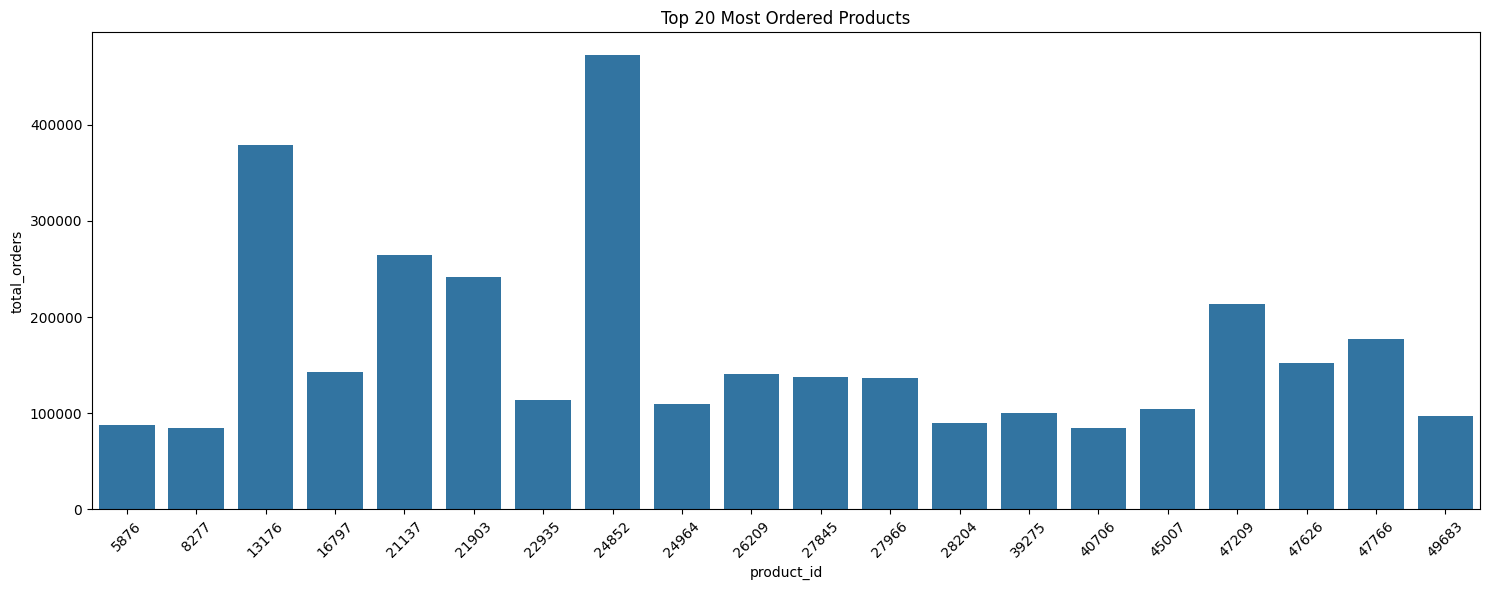

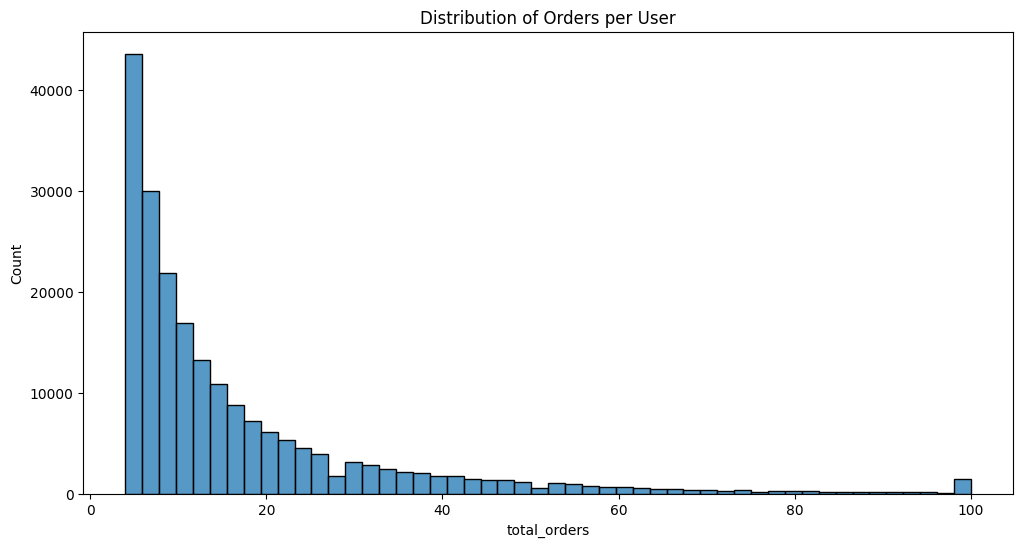

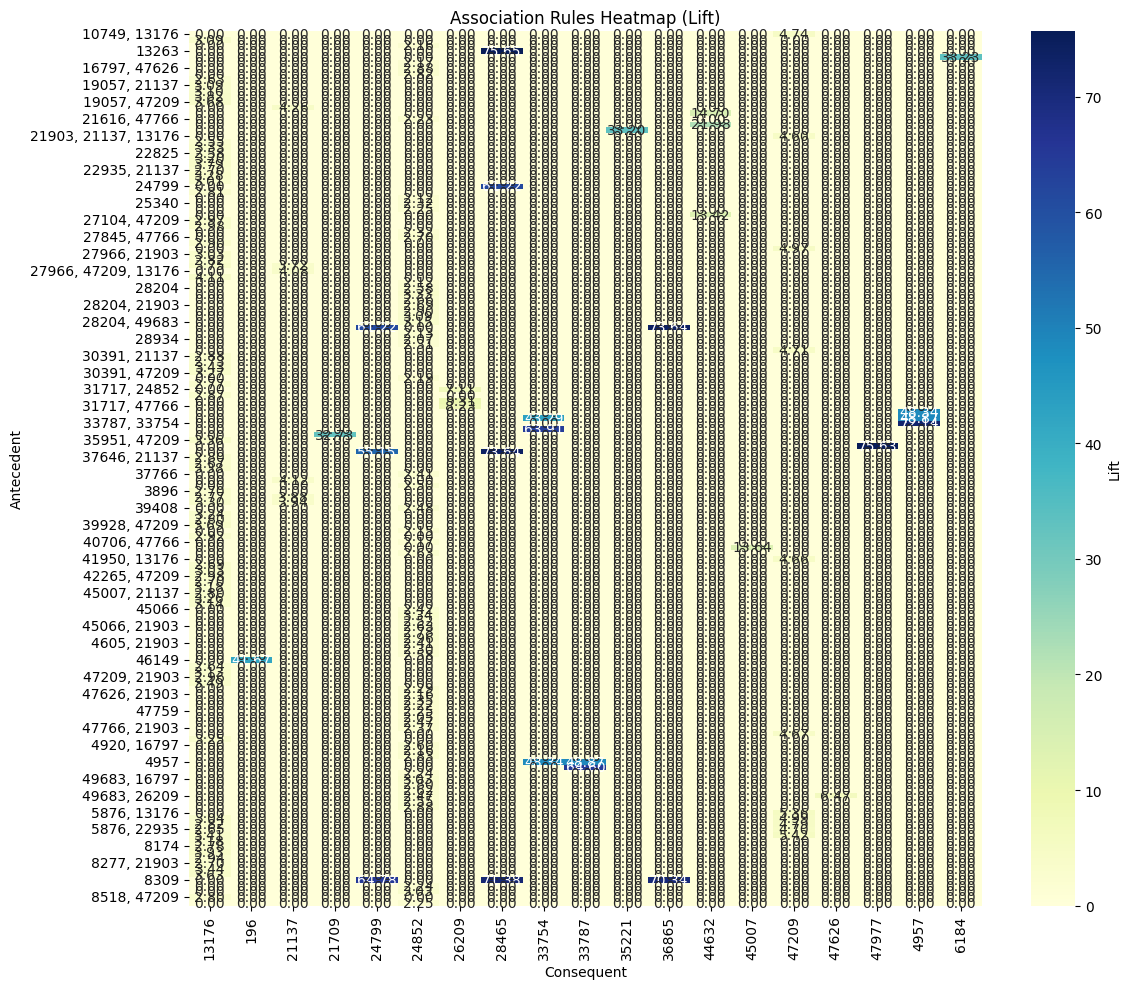

In [ ]:
# 6. Create visualizations
print("Generating visualizations...")
create_visualizations(product_features, user_features, association_rules)

In [ ]:
# 7. Calculate and display metrics
print("Calculating performance metrics...")
als_metrics = calculate_performance_metrics(als_predictions)
reorder_metrics = calculate_performance_metrics(reorder_predictions)
# spark_metrics = monitor_spark_performance()

Calculating performance metrics...


In [ ]:
print("\nModel Performance Metrics:")
print(f"ALS Model Metrics: {als_metrics}")
print(f"Reorder Prediction Metrics: {reorder_metrics}")
# print(f"Spark Performance Metrics: {spark_metrics}")


Model Performance Metrics:
ALS Model Metrics: {'AUC (Area Under ROC)': 0.757473768019179}
Reorder Prediction Metrics: {'AUC (Area Under ROC)': 0.6566510805714427}


In [ ]:
import pandas as pd

def get_roc_data(predictions_df):
    return predictions_df.select("prediction", "reordered").toPandas()


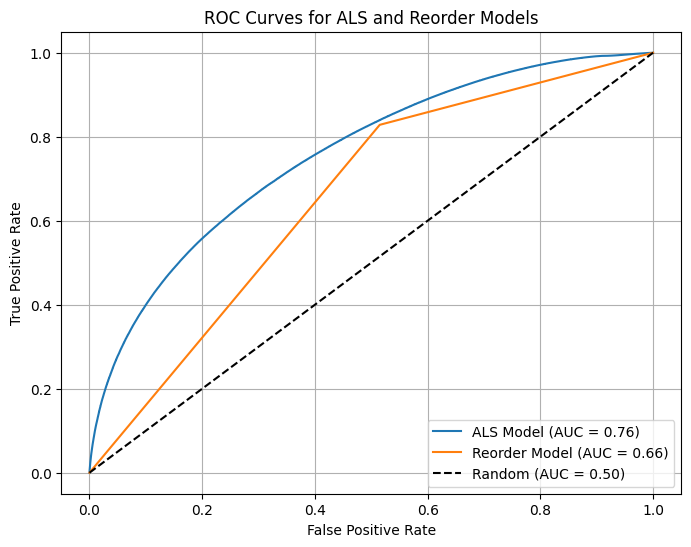

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(predictions_pd, model_name):
    fpr, tpr, _ = roc_curve(predictions_pd["reordered"], predictions_pd["prediction"])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Get Pandas DataFrames
als_pd = get_roc_data(als_predictions)
reorder_pd = get_roc_data(reorder_predictions)

# Plot
plt.figure(figsize=(8, 6))
plot_roc_curve(als_pd, "ALS Model")
plot_roc_curve(reorder_pd, "Reorder Model")
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for ALS and Reorder Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
k = 10
top_k_preds = get_top_k_recommendations(als_predictions, k)
precision_recall_metrics = compute_precision_recall_at_k(top_k_preds, reorder_predictions, k)

print(precision_recall_metrics)


{'Precision@10': 0.3658340187111852, 'Recall@10': 0.18628168618295088}
